<a href="https://colab.research.google.com/github/ffatmanurggultekin/scoliosis-detection/blob/main/ensemble_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader


In [ ]:
from google.colab import drive # Import the google.colab.drive module

# Define your data directories
drive.mount('/content/drive') # Now you can use the drive object to mount your Google Drive
train_dir = '/content/drive/My Drive/train_imadjust_sobel_diff_alpha0.5'
val_dir = '/content/drive/My Drive/validation_imadjust_sobel_diff_alpha0.5'
test_dir = '/content/drive/My Drive/test_imadjust_sobel_diff_alpha0.5'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
# Load InceptionV3 model
model = models.inception_v3(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Identity()  # Remove the classification head
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 181MB/s] 


In [ ]:
# Extract features function
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())

    features = np.vstack(features)
    return features, labels

In [ ]:
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Extracting features for cross-validation...")
train_features, train_labels = extract_features(model, train_loader)
val_features, val_labels = extract_features(model, val_loader)
all_features = np.concatenate((train_features, val_features), axis=0)
all_labels = np.concatenate((train_labels, val_labels), axis=0)

accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(all_features, all_labels)):
    print(f"\n=== Fold {fold + 1} ===")
    fold_train_features, fold_val_features = all_features[train_idx], all_features[val_idx]
    fold_train_labels, fold_val_labels = all_labels[train_idx], all_labels[val_idx]

    # Train SVM
    svm = SVC(kernel='linear', probability=True)
    svm.fit(fold_train_features, fold_train_labels)

    # Validate SVM
    fold_val_preds = svm.predict(fold_val_features)
    accuracy_list.append((fold_val_preds == fold_val_labels).mean())
    precision_list.append(precision_score(fold_val_labels, fold_val_preds))
    recall_list.append(recall_score(fold_val_labels, fold_val_preds))
    f1_list.append(f1_score(fold_val_labels, fold_val_preds))

print("\nCross-Validation Results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
print(f"F1-Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

Extracting features for cross-validation...

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

Cross-Validation Results:
Accuracy: 0.9530 ± 0.0395
Precision: 0.9677 ± 0.0204
Recall: 0.9677 ± 0.0408
F1-Score: 0.9674 ± 0.0276


In [ ]:
# Test set evaluation
print("Extracting features from test data...")
test_features, test_labels = extract_features(model, test_loader)

print("Evaluating on test set...")
test_preds = svm.predict(test_features)

Extracting features from test data...
Evaluating on test set...



Test Set Confusion Matrix:
[[11  1]
 [ 3 26]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.92      0.85        12
        Scol       0.96      0.90      0.93        29

    accuracy                           0.90        41
   macro avg       0.87      0.91      0.89        41
weighted avg       0.91      0.90      0.90        41



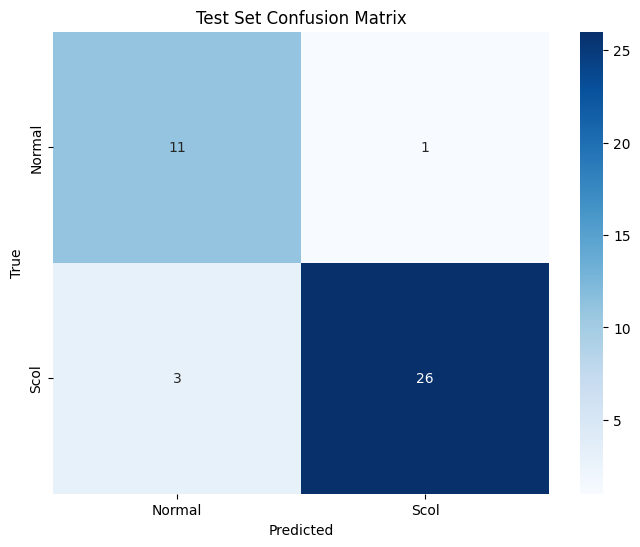

In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(test_labels, test_preds)
print("\nTest Set Confusion Matrix:")
print(cm)
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
